This is a notebook that use the FLOCELLID_taxa.tab file in the WGS folder to generate ncbi hit plot for the four flowcells.

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from itertools import product

In [2]:
BASEDIR = '/home/yiheng/analysis/WGS'

In [3]:
# get the summary dataframe for total reads
FC1_totaltaxa = os.path.join(BASEDIR, 'run1_totaltaxa.tab')
FC2_totaltaxa = os.path.join(BASEDIR, 'run2_totaltaxa.tab')
FC3_totaltaxa = os.path.join(BASEDIR, 'FAH05432_totaltaxa.tab')
FC4_totaltaxa = os.path.join(BASEDIR, 'FAH05731_totaltaxa.tab')

FC1_totaltaxa_df = pd.read_csv(FC1_totaltaxa, sep = '\t')
FC2_totaltaxa_df = pd.read_csv(FC2_totaltaxa, sep = '\t')
FC3_totaltaxa_df = pd.read_csv(FC3_totaltaxa, sep = '\t')
FC4_totaltaxa_df = pd.read_csv(FC4_totaltaxa, sep = '\t')

# now get the summary dataframe for nt hit reads
FC1_nttaxa = os.path.join(BASEDIR, 'run1_nttaxa.tab')
FC2_nttaxa = os.path.join(BASEDIR, 'run2_nttaxa.tab')
FC3_nttaxa = os.path.join(BASEDIR, 'FAH05432_nttaxa.tab')
FC4_nttaxa = os.path.join(BASEDIR, 'FAH05731_nttaxa.tab')

FC1_nttaxa_df = pd.read_csv(FC1_nttaxa, sep = '\t')
FC2_nttaxa_df = pd.read_csv(FC2_nttaxa, sep = '\t')
FC3_nttaxa_df = pd.read_csv(FC3_nttaxa, sep = '\t')
FC4_nttaxa_df = pd.read_csv(FC4_nttaxa, sep = '\t')

In [4]:
joint_totaltaxa_df = pd.concat([FC1_totaltaxa_df,  
                                FC2_totaltaxa_df,
                                FC3_totaltaxa_df,
                                FC4_totaltaxa_df], ignore_index=True)
joint_nttaxa_df = pd.concat([FC1_nttaxa_df,  
                             FC2_nttaxa_df,
                             FC3_nttaxa_df,
                             FC4_nttaxa_df], ignore_index=True)

In [5]:
len(joint_totaltaxa_df[joint_totaltaxa_df.barcode_arrangement.str.contains('barcode05')])

274003

In [6]:
#Defines a function to make manual adjustments to the NCBI taxonomic sorting
def manually_adjust_ncbi_taxonomy(rank_select, entry_select, ranks_to_edit, new_entry):
    """Select dataframe entries to edit by a specific rank (rank_select) 
    and entry related to that rank (entry_select), 
    provide a list of ranks to edit for those selected entries (ranks_to_edit),
    replace these ranks with a new entry (new_entry)"""
    if entry_select in list(joint_nttaxa_df[rank_select].unique()):
        selection = (joint_nttaxa_df[rank_select] == entry_select)
        selected_tax_ranks = ranks_to_edit
        for ranks in selected_tax_ranks:
            joint_nttaxa_df[ranks][selection] = new_entry

In [7]:
manually_adjust_ncbi_taxonomy('species', 
                            'Cloning vector lambda TXF97', 
                            ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus'], 
                            'Cloning vector lambda TXF97')

manually_adjust_ncbi_taxonomy('superkingdom', 
                            'Viruses', 
                            ['phylum', 'class'], 
                            'dsDNA viruses, no RNA stage')

In [8]:
#count pivot table of dataframe with taxonomic columns: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_ncbi_taxonomy_pivot(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank counts, sorted by bcs"""
    pivot_table = tax_df.pivot_table(values='order', 
                                            index=rank, 
                                            columns='barcode_arrangement', 
                                            aggfunc='count', 
                                            fill_value=0)
    pivot_table.columns.name = None
    return pivot_table.sort_values(bcs, axis=0, ascending=False).head(n=num)

In [9]:
generate_ncbi_taxonomy_pivot(joint_nttaxa_df, 'family','barcode04',5)

,barcode01,barcode02,barcode03,barcode04,barcode05
family,,,,,
Pseudomonadaceae,2457,1913,38,2736,218
Pleosporaceae,113,454,9,359,137
Sphingomonadaceae,3,303,4,198,6
Hymenobacteraceae,1,125,1,92,3
Mycosphaerellaceae,7,298,4,86,5


In [10]:
total_no_of_each_barcode_df = pd.DataFrame({'barcode01':len(joint_totaltaxa_df[joint_totaltaxa_df.barcode_arrangement.str.contains('barcode01')]),
                                            'barcode02':len(joint_totaltaxa_df[joint_totaltaxa_df.barcode_arrangement.str.contains('barcode02')]),
                                            'barcode03':len(joint_totaltaxa_df[joint_totaltaxa_df.barcode_arrangement.str.contains('barcode03')]),
                                            'barcode04':len(joint_totaltaxa_df[joint_totaltaxa_df.barcode_arrangement.str.contains('barcode04')]),
                                            'barcode05':len(joint_totaltaxa_df[joint_totaltaxa_df.barcode_arrangement.str.contains('barcode05')])},index = [0])

In [11]:
pivot_df = generate_ncbi_taxonomy_pivot(joint_nttaxa_df, 'genus','barcode04',10)

In [12]:
# % pivot table of dataframe with taxonomic columns: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_ncbi_taxonomy_pivot_pc(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank %, sorted ascending by bcs"""
    pivot_table_pc = generate_ncbi_taxonomy_pivot(tax_df, rank, bcs, num)
    
    for ind, brcs in enumerate(pivot_table_pc.columns):
        pivot_table_pc[str(brcs) + '%'] = pivot_table_pc[brcs].apply(lambda x: (x / total_no_of_each_barcode_df.iloc[0,ind])*100)
    for brcs in pivot_table_pc.columns:
        if '%' not in brcs:
            pivot_table_pc.drop(brcs, axis=1, inplace=True)
    

    pivot_table_pc2 = pivot_table_pc.sort_values(str(bcs) + '%', axis=0, ascending=False)
    return pivot_table_pc2.applymap(lambda x: '%.3f' % x).head(n=num)

In [13]:
generate_ncbi_taxonomy_pivot_pc(joint_nttaxa_df, 'species', 'barcode01', 10)

,barcode01%,barcode02%,barcode03%,barcode04%,barcode05%
species,,,,,
Pseudomonas syringae,0.588,0.332,0.003,0.427,0.020
Pseudomonas poae,0.058,0.089,0.009,0.171,0.015
Alternaria alternata,0.024,0.096,0.002,0.075,0.034
Erwinia tasmaniensis,0.017,0.000,0.000,0.000,0.000
Puccinia graminis,0.017,0.000,0.000,0.002,0.000
Pseudomonas cerasi,0.015,0.026,0.000,0.010,0.001
Erwinia pyrifoliae,0.015,0.001,0.000,0.000,0.000
Erwinia billingiae,0.015,0.000,0.000,0.000,0.000
Pseudomonas savastanoi,0.012,0.004,0.000,0.004,0.000


In [14]:
#Assesses number of barcodes, generates necessary number of plots (even) and relevant indexing system
ncbiblast_barcodes = list(joint_nttaxa_df['barcode_arrangement'].unique())
no_of_subplots = len(ncbiblast_barcodes)+1

In [15]:
#Always 2 columns, bc-count/2 rows 
no_of_subplots_pair = [int(no_of_subplots/2), 2]

#Produce pairs of indices correlating to the coordinates of the subplots
subplot_coordinates = list(product(range(no_of_subplots_pair[0]), range(no_of_subplots_pair[1])))
subplot_coordinates_list = [list(l) for l in subplot_coordinates]
subplot_coordinates_list_rows = [i[0] for i in subplot_coordinates_list]
subplot_coordinates_list_columns = [i[1] for i in subplot_coordinates_list]

fig, ax = plt.subplots(no_of_subplots_pair[1], no_of_subplots_pair[0], figsize=(20, 6))

In [16]:
name_list = ['Stripe rust', 'Septoria tritici blotch', 'Healthy wheat', 'Stripe rust and septoria tritici blotch', 'Yellow spot']

In [17]:
def get_color(x):
    x = x%10
    return ('#%02X%02X%02X' % (int(plt.cm.tab10.colors[x][0]*255),int(plt.cm.tab10.colors[x][1]*255),int(plt.cm.tab10.colors[x][2]*255)))

def applyTaxPlotStyle(ax_ind1, ax_ind2, bcs, rank, name):
    labels = ''
    labels = tuple(generate_ncbi_taxonomy_pivot_pc(joint_nttaxa_df, rank, bcs, 10)[bcs + '%'].index)
    y_pos = ''
    y_pos = np.arange(len(labels))
    sizes = ''
    sizes = tuple([float(i) for i in generate_ncbi_taxonomy_pivot_pc(joint_nttaxa_df, rank, bcs, 10)[bcs + '%']])
    
    ax[ax_ind1, ax_ind2].barh(y_pos, sizes, align='center', alpha=0.4, color=get_color(2*ax_ind2 + ax_ind1))
    ax[ax_ind1, ax_ind2].set_yticks(y_pos)
    ax[ax_ind1, ax_ind2].set_yticklabels(labels)
    ax[ax_ind1, ax_ind2].tick_params(top="off", right="off", left="off")
    ax[ax_ind1, ax_ind2].set_xlabel('Percentage of Total Reads Hitting NCBI')
    ax[ax_ind1, ax_ind2].set_xticks(range(0, 2),0.2)
    ax[ax_ind1, ax_ind2].set_title(name, fontsize=14)
    ax[ax_ind1, ax_ind2].invert_yaxis()
    ax[ax_ind1, ax_ind2].grid(b=None, which='major', axis='x', linestyle='dashed', linewidth=0.2)
    ax[ax_ind1, ax_ind2].annotate('E = 0.00001', 
             xy=(1.06, 0.3), xycoords='axes fraction', fontsize=14, xytext=(-20, -30), textcoords='offset points', 
             ha='right', va='bottom')

    
def generateTaxSubplots(search_rank):
    for ax_ind1, ax_ind2, bcs, name in zip(subplot_coordinates_list_columns, subplot_coordinates_list_rows, ncbiblast_barcodes, name_list):
        applyTaxPlotStyle(ax_ind1, ax_ind2, bcs, search_rank, name)    

    if len(list(joint_nttaxa_df['barcode_arrangement'].unique())) != 0:
        plt.delaxes(ax[subplot_coordinates_list_columns[-1], subplot_coordinates_list_rows[-1]])
    
    plt.suptitle('Reads Hitting NCBI Database - Percentage By ' + str(search_rank).title() + ' By Sample', 
             fontsize='xx-large',
             y=1.02,
             fontweight="bold")
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.4, hspace=0.4)
    plt.tight_layout()
    
    plt.savefig(BASEDIR + '/figures/' + 'figure3_%s.png' % search_rank, bbox_inches='tight', dpi = 600)
    plt.show()
            


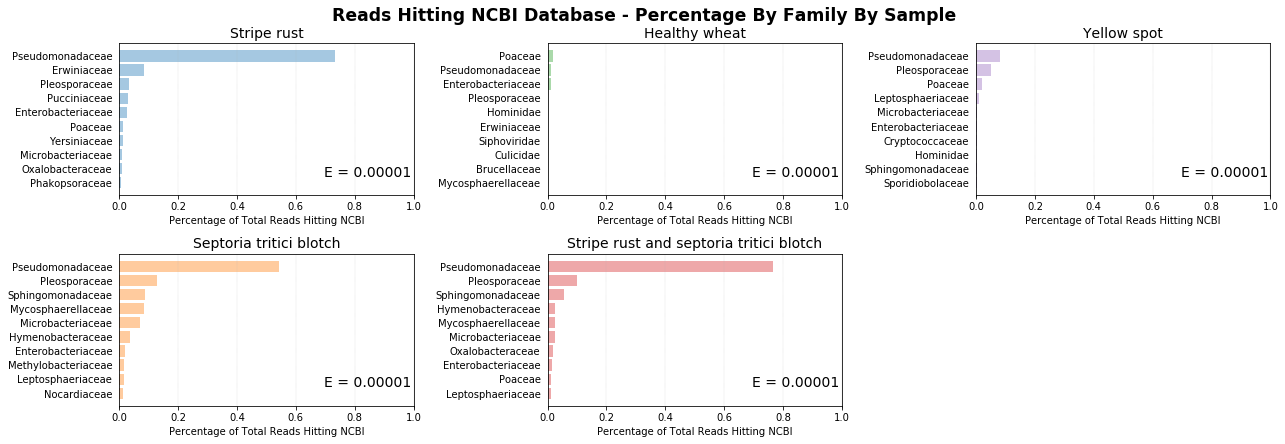

In [19]:
fig, ax = plt.subplots(no_of_subplots_pair[1], no_of_subplots_pair[0], figsize=(18, 6))
generateTaxSubplots('family')